In [1]:
import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.image as mpimg

In [11]:
#data imported from https://github.com/CoreyCole/HypDB/blob/master/demo/server/resources/data/binadult.csv
conn = sqlite3.connect('adult.db') 
cur = conn.cursor()
query = """SELECT sql FROM sqlite_master WHERE name='adult';"""
cur.execute(query)
rows = cur.fetchall()

print("Schema for Adult table:")
print(rows[0][0])

Schema for Adult table:
CREATE TABLE adult(
  "age" TEXT,
  "workclass" TEXT,
  "education" TEXT,
  "educationnum" TEXT,
  "maritalstatus" TEXT,
  "occupation" TEXT,
  "relationship" TEXT,
  "race" TEXT,
  "sex" TEXT,
  "capitalgain" TEXT,
  "capitalloss" TEXT,
  "hoursperweek" TEXT,
  "nativecountry" TEXT,
  "income" TEXT
)


Apparent Bias?


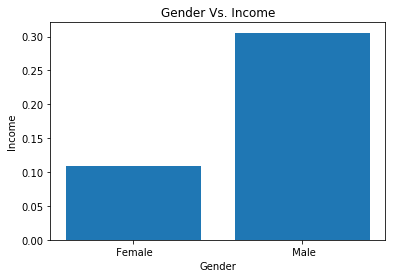

In [12]:
query =  """SELECT sex, avg(income) 
            FROM adult 
            GROUP BY sex;"""
cur.execute(query)
rows = cur.fetchall()
    
gender = []
income = []
for row in rows:
    gender.append(row[0])
    income.append(row[1])
    
genderVsIncome = (gender, income)

plt.bar(*genderVsIncome);
plt.ylabel('Income');
plt.xlabel('Gender');
plt.title("Gender Vs. Income");
print("Apparent Bias?")


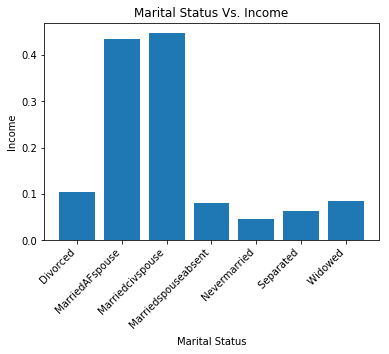

In [4]:
query =  """SELECT maritalstatus, avg(income) 
            FROM adult 
            GROUP BY maritalstatus;"""
cur.execute(query)
rows = cur.fetchall()

maritalstatus = []
income = []
for row in rows:
    maritalstatus.append(row[0])
    income.append(row[1])
    
maritalstatusVsIncome = (maritalstatus, income)

plt.bar(*maritalstatusVsIncome);
plt.xticks(rotation=45, ha='right');
plt.ylabel('Income');
plt.xlabel('Marital Status');
plt.title("Marital Status Vs. Income");


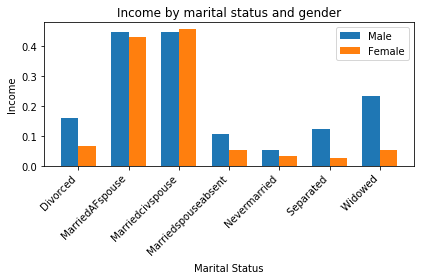

In [5]:
query =  """SELECT sex, maritalstatus, avg(income) 
            FROM adult 
            GROUP BY sex, maritalstatus;"""
cur.execute(query)
rows = cur.fetchall()

fMs = []
fIncome = []
mMs = []
mIncome = []
for row in rows:
    if row[0]==' Female':
        fIncome.append(row[2])
    else:
        mIncome.append(row[2])

x = np.arange(len(maritalstatus))  # the label location
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mIncome, width, label='Male')
rects2 = ax.bar(x + width/2, fIncome, width, label='Female')

ax.set_ylabel('Income')
ax.set_xlabel('Marital Status');
ax.set_title('Income by marital status and gender')
ax.set_xticks(x)
ax.set_xticklabels(maritalstatus)
ax.legend()
plt.xticks(rotation=45, ha='right');


fig.tight_layout()
plt.show()
        

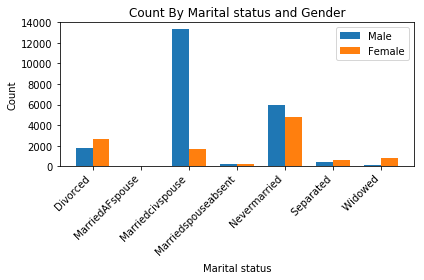

As HypeDB found, bias mainly coming from the number skewed number of married men/women


In [13]:
query =  """SELECT sex, maritalstatus, COUNT(*) 
            FROM adult 
            GROUP BY sex, maritalstatus;"""
cur.execute(query)
rows = cur.fetchall()

fN = []
mN = []
for row in rows:
    if row[0]==' Female':
        fN.append(row[2])
    else:
        mN.append(row[2])

x = np.arange(len(maritalstatus)) 
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mN, width, label='Male')
rects2 = ax.bar(x + width/2, fN, width, label='Female')

ax.set_ylabel('Count')
ax.set_xlabel('Marital status')
ax.set_title('Count By Marital status and Gender')
ax.set_xticks(x)
ax.set_xticklabels(maritalstatus)
ax.legend()
plt.xticks(rotation=45, ha='right');

fig.tight_layout()
plt.show()


print("As HypeDB found, bias mainly coming from the number skewed number of married men/women")

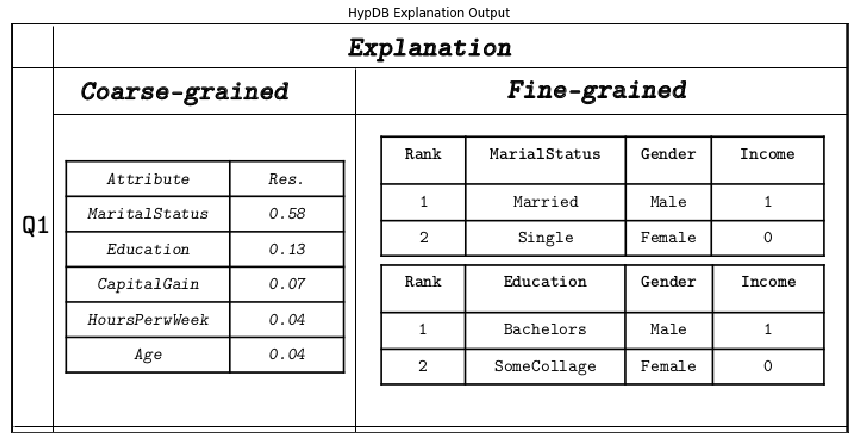

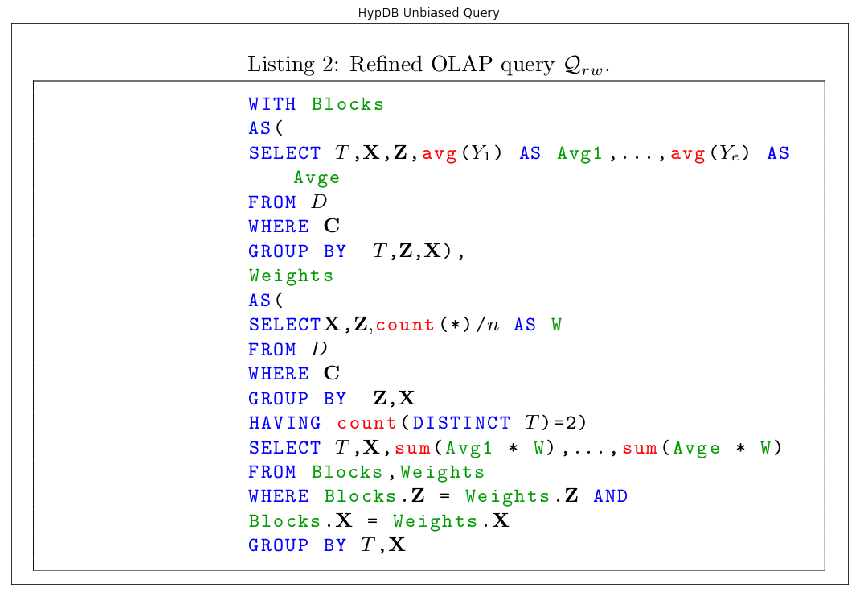

In [7]:
img=mpimg.imread('biasQuery.png') #https://arxiv.org/abs/1803.04562
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img);
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.title('HypDB Explanation Output');

img=mpimg.imread('generalQuery.png') #https://arxiv.org/abs/1803.04562
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img);
ax.xaxis.set_ticks([]);
ax.yaxis.set_ticks([]);
plt.title('HypDB Unbiased Query');

In [8]:
query = """
WITH Blocks AS (
    SELECT sex, maritalstatus, avg(income) AS Avge
    FROM adult
    GROUP BY sex, maritalstatus),
Weights AS (
    SELECT maritalstatus, count(*)/(SELECT count(*) FROM adult) AS W
    FROM adult
    GROUP BY maritalstatus
    HAVING count(DISTINCT sex)=2)
SELECT sex, sum(Avge*W)
FROM Blocks, Weights
WHERE Blocks.maritalstatus = Weights.maritalstatus
GROUP BY sex"""
cur.execute(query)
rows = cur.fetchall()
rows


[(' Female', 0.0), (' Male', 0.0)]

In [9]:
conn.close()